# Proyek Klasifikasi Gambar: Food Image Classification Dataset
- **Nama:** Zaenal Alfian
- **Email:** zaenal.alfian@mhs.rosma.ac.id
- **ID Dicoding:** zaenal_alfian

## Import Semua Packages/Library yang Digunakan

In [ ]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dretham25","key":"02564020ecadbc9f69b83f77b15e6d08"}'}

In [ ]:
!kaggle datasets download -d harishkumardatalab/food-image-classification-dataset
!unzip food-image-classification-dataset

Streaming output truncated to the last 5000 lines.
  inflating: Food Classification dataset/idli/277.jpg  
  inflating: Food Classification dataset/idli/278.jpg  
  inflating: Food Classification dataset/idli/280.jpg  
  inflating: Food Classification dataset/idli/282.jpg  
  inflating: Food Classification dataset/idli/283.jpg  
  inflating: Food Classification dataset/idli/284.jpg  
  inflating: Food Classification dataset/idli/285.jpg  
  inflating: Food Classification dataset/idli/286.jpg  
  inflating: Food Classification dataset/idli/287.jpg  
  inflating: Food Classification dataset/idli/288.jpg  
  inflating: Food Classification dataset/idli/290.jpg  
  inflating: Food Classification dataset/idli/292.jpg  
  inflating: Food Classification dataset/idli/293.jpg  
  inflating: Food Classification dataset/idli/295.jpg  
  inflating: Food Classification dataset/idli/296.jpg  
  inflating: Food Classification dataset/idli/297.jpg  
  inflating: Food Classification dataset/idli/299.jpg

In [ ]:
# Path ke direktori utama dataset
base_dir = 'Food Classification dataset'

# List semua kelas makanan
food_list = os.listdir(base_dir)

# Inisialisasi list untuk menyimpan data gambar
image_paths = []
labels = []

# Loop melalui setiap kelas makanan
for food_item in food_list:
  food_dir = os.path.join(base_dir, food_item)
  # Loop melalui setiap gambar dalam kelas makanan
  for image_file in os.listdir(food_dir):
    image_path = os.path.join(food_dir, image_file)
    image_paths.append(image_path)
    labels.append(food_item)

# Buat DataFrame dari list
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Tampilkan DataFrame
df.head()

,image_path,label
0,Food Classification dataset/apple_pie/1617793.jpg,apple_pie
1,Food Classification dataset/apple_pie/3897758.jpg,apple_pie
2,Food Classification dataset/apple_pie/128259.jpg,apple_pie
3,Food Classification dataset/apple_pie/481805.jpg,apple_pie
4,Food Classification dataset/apple_pie/946403.jpg,apple_pie


In [ ]:
# Seperates the classes we are iterested in from the dataset
Classes = ['Baked Potato', 'Crispy Chicken', 'Donut', 'Sandwich', 'Taco', 'Taquito', 'Fries']

df = df[df['label'].isin(Classes)]

df.reset_index(inplace=True, drop=True)
df.head()

,image_path,label
0,Food Classification dataset/Taco/Taco-Train (1...,Taco
1,Food Classification dataset/Taco/Taco-Train (7...,Taco
2,Food Classification dataset/Taco/Taco-Train (9...,Taco
3,Food Classification dataset/Taco/Taco-Train (1...,Taco
4,Food Classification dataset/Taco/Taco-Train (1...,Taco


<Axes: xlabel='label', ylabel='count'>

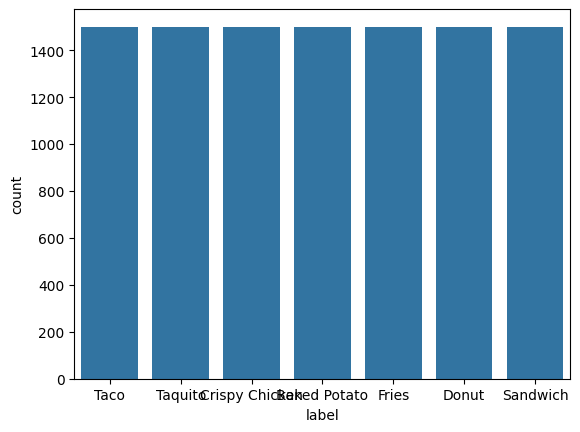

In [ ]:
import seaborn as sns
sns.countplot(df, x="label")

In [ ]:
# Mengubah nama label menjadi nilai numerik
df['label'] = df['label'].replace(['Baked Potato', 'Crispy Chicken', 'Donut', 'Sandwich', 'Taco', 'Taquito', 'Fries'],
                                       [0, 1, 2, 3, 4, 5, 6])

# Pastikan semua label adalah integer
df['label'] = df['label'].astype(int)

### Data Preprocessing

#### Split Dataset

In [ ]:
# Membagi dataset menjadi 80% data train dan 20% data test
train,val= train_test_split(df, test_size=0.2, random_state=42,shuffle=True, stratify=df['label'])

#takes the 20 split and takes 1/2 of it to create a 80-10-10 split for training-validation-testing
val,test= train_test_split(val, test_size=1.0/2.0, random_state=42,shuffle=True, stratify=val['label'])

<Axes: xlabel='label', ylabel='count'>

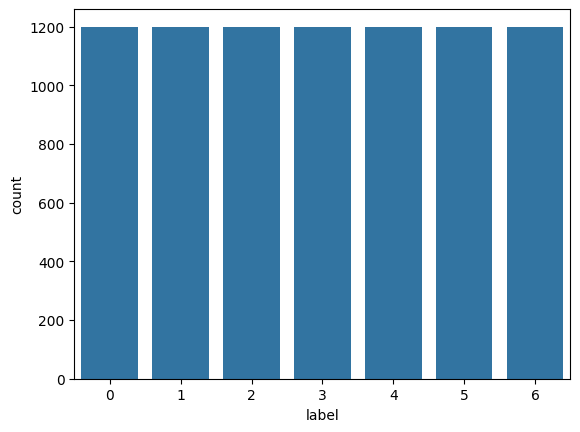

In [ ]:
sns.countplot(train, x="label")

In [ ]:
#Counts the number of each class
count=(train.label.value_counts()).to_frame()
count.reset_index(inplace=True)
count.columns=['label','count']
count

,label,count
0,0,1200
1,2,1200
2,3,1200
3,6,1200
4,1,1200
5,5,1200
6,4,1200


In [ ]:
#Determines how many of each class to augment to balance set
count['to_Augment'] = (count['count'].max() - count['count']).astype(int)
count

,label,count,to_Augment
0,0,1200,0
1,2,1200,0
2,3,1200,0
3,6,1200,0
4,1,1200,0
5,5,1200,0
6,4,1200,0


In [ ]:
#Takes images from the classes with lower than max images to balance the classes
augment = pd.DataFrame(columns = ['filename', 'label'])
for i, items in count.iterrows():
    augment = pd.concat([augment, train[(train.label == items['label'])].sample(items['to_Augment'])], ignore_index=True)
augment['label'] = augment['label'].astype(int)

In [ ]:
# Konversi dataframe menjadi tensor
temp = train['image_path'].to_numpy()
traindf = tf.data.Dataset.from_tensor_slices(temp)
temp = train['label'].to_numpy()
labels = tf.data.Dataset.from_tensor_slices(temp)
traindf = tf.data.Dataset.zip((traindf, labels))

temp = augment['filename'].to_numpy()
augmentdf = tf.data.Dataset.from_tensor_slices(temp)
temp = augment['label'].to_numpy()
labels = tf.data.Dataset.from_tensor_slices(temp)
augmentdf = tf.data.Dataset.zip((augmentdf, labels))

temp = val['image_path'].to_numpy()
valdf = tf.data.Dataset.from_tensor_slices(temp)
temp = val['label'].to_numpy()
labels = tf.data.Dataset.from_tensor_slices(temp)
valdf = tf.data.Dataset.zip((valdf, labels))

temp = test['image_path'].to_numpy()
testdf = tf.data.Dataset.from_tensor_slices(temp)
temp = test['label'].to_numpy()
labels = tf.data.Dataset.from_tensor_slices(temp)
testdf = tf.data.Dataset.zip((testdf, labels))

In [ ]:
# Menampilkan tensor
for image,label in traindf.take(5):
    print(image.numpy())
    print(label.numpy())

b'Food Classification dataset/Baked Potato/Baked Potato-Train (934).jpeg'
0
b'Food Classification dataset/Donut/Donut (631).jpeg'
2
b'Food Classification dataset/Baked Potato/Baked Potato-Train (960).jpeg'
0
b'Food Classification dataset/Sandwich/Sandwich-Train (237).jpeg'
3
b'Food Classification dataset/Baked Potato/Baked Potato-Train (1480).jpeg'
0


In [ ]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_image(img, channels=3, expand_animations = False)
    # Resize the image to the desired size
    return tf.image.resize(img, [256, 256])

In [ ]:
def process_path(file_path, label):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
import re
import random

rng = tf.random.Generator.from_seed(4711, alg='philox')
def data_augment(image, label):
    # fill here with data augmentation manipulations later
    seed = rng.make_seeds(2)[0]
    image = tf.image.stateless_random_brightness(image, 0.25, seed)
    image = tf.image.stateless_random_contrast(image, 0.9, 1.5, seed)
    image = tf.image.stateless_random_hue(image, 0.3, seed)
    image = tf.image.stateless_random_saturation(image, 1, 1.5, seed)
    image = tf.image.stateless_random_flip_left_right(image, seed)
    image = tf.image.stateless_random_flip_up_down(image, seed)
    coeff1 = random.uniform(0.7, 0.9)
    coeff2 = random.uniform(0.7, 0.9)
    crop = [int(256*coeff1), int(256*coeff2)]
    #image = tf.image.stateless_random_crop(image, (crop[0], crop[1],3),
    #                                      seed)
    image = tf.image.resize(image, [256, 256])
    return image, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
class_names = np.array(Classes)

BATCH_SIZE = 32
#Calling functions to decode file paths into images
traindf = traindf.map(process_path, num_parallel_calls=AUTOTUNE)
augmentdf = augmentdf.map(process_path, num_parallel_calls=AUTOTUNE)

#Augmenting seperated images from earlier and combining with regular trainset
augmentdf = augmentdf.map(data_augment, num_parallel_calls=AUTOTUNE)
augmentdf = augmentdf.concatenate(traindf)
train_size = tf.data.experimental.cardinality(traindf).numpy()

traindf = traindf.repeat()
traindf = traindf.batch(BATCH_SIZE)
traindf = traindf.prefetch(AUTOTUNE)

augment_size = tf.data.experimental.cardinality(augmentdf).numpy()
augmentdf = traindf.repeat()
augmentdf = traindf.batch(BATCH_SIZE)
augmentdf = traindf.prefetch(AUTOTUNE)

valdf = valdf.map(process_path, num_parallel_calls=AUTOTUNE)
val_size = tf.data.experimental.cardinality(valdf).numpy()
valdf = valdf.batch(BATCH_SIZE)
valdf = valdf.cache()
valdf = valdf.prefetch(AUTOTUNE)

testdf = testdf.map(process_path, num_parallel_calls=AUTOTUNE)
test_size = tf.data.experimental.cardinality(testdf).numpy()
testdf = testdf.batch(BATCH_SIZE)
testdf = testdf.prefetch(AUTOTUNE)

In [ ]:
print(train_size)
print(augment_size)
print(val_size)
print(test_size)

8400
8400
1050
1050


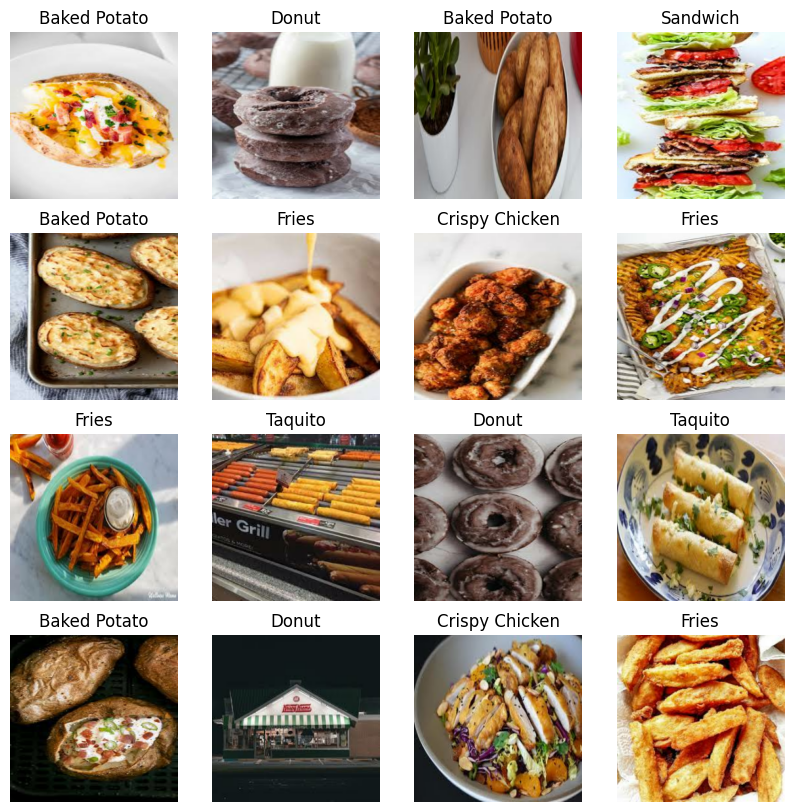

In [ ]:
import matplotlib.pyplot as plt

image, label = next(traindf.take(1).as_numpy_iterator())
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(image[i,:,:,:].astype("uint8"))
    plt.axis("off")
    plt.title(Classes[label[i]])

## Modelling

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 128)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 126, 126, 128)     512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                        

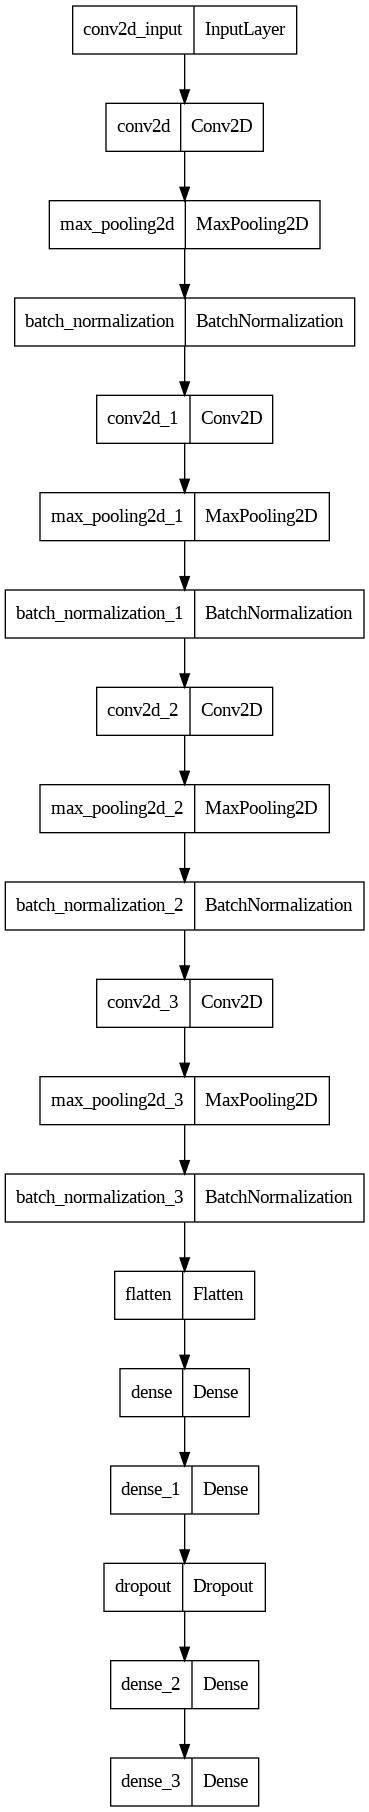

In [ ]:
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, (5, 5), input_shape=(256, 256, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        keras.layers.Dense(128, kernel_regularizer=keras.regularizers.L2(1e-4), activation='relu'),
        keras.layers.Dense(64, kernel_regularizer=keras.regularizers.L2(1e-4), activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, kernel_regularizer=keras.regularizers.L2(1e-4), activation='relu'),
        tf.keras.layers.Dense(len(Classes), activation='softmax')
        ])
print(model.summary())
keras.utils.plot_model(model)

In [ ]:
history = []
# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,amsgrad=False),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
LR_START = 0.001
LR_MAX = 0.0005
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_EXP_DECAY = 0.5

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = LR_START
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY ** (epoch - LR_RAMPUP_EPOCHS) + LR_MIN
    return lr

local_save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
lr_callback = keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
cp_callback = keras.callbacks.ModelCheckpoint('model.h5',
                                              verbose=1,
                                              save_best_only=True,
                                              save_options=local_save_options)

In [ ]:
EPOCHS = 20
STEPS_PER_EPOCH = train_size // BATCH_SIZE

history.append(model.fit(
    traindf,
    validation_data=valdf,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback, cp_callback]
))


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
262/262 [==============================] - ETA: 0s - loss: 0.9323 - accuracy: 0.7129
Epoch 1: val_loss did not improve from 1.64079
262/262 [==============================] - 41s 157ms/step - loss: 0.9323 - accuracy: 0.7129 - val_loss: 2.0846 - val_accuracy: 0.4686 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/20
262/262 [==============================] - ETA: 0s - loss: 0.7511 - accuracy: 0.7932
Epoch 2: val_loss did not improve from 1.64079
262/262 [==============================] - 41s 155ms/step - loss: 0.7511 - accuracy: 0.7932 - val_loss: 2.0815 - val_accuracy: 0.5038 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/20
262/262 [==============================] - ETA: 0s - loss: 0.5649 - accuracy: 0.8630
Epoch 3: val_loss did not improve from 1.64079
262/262 [==============================] - 41s 156ms/step - loss: 0.5649 - accuracy: 

## Evaluasi dan Visualisasi

33/33 [==============================] - 1s 42ms/step - loss: 2.6579 - accuracy: 0.5600
Test Loss: 2.657897710800171
Test Accuracy: 0.5600000023841858


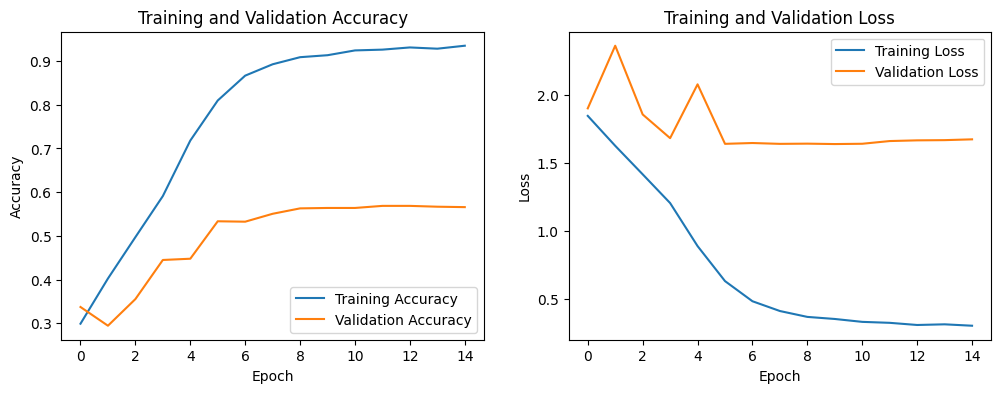

In [ ]:
# Evaluasi model pada data test
test_loss, test_accuracy = model.evaluate(testdf)

# Cetak hasil evaluasi
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Visualisasi akurasi dan loss model
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history[0].history['accuracy'], label='Training Accuracy')
plt.plot(history[0].history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history[0].history['loss'], label='Training Loss')
plt.plot(history[0].history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

## Konversi Model

In [ ]:
model.save("model.h5")

In [ ]:
# Install tensorflowjs
!pip install tensorflowjs

# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 78.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9

2024-07-19 04:11:53.983060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 04:11:54.008364: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 04:11:54.008433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-19 04:11:55.068002: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Konversi model ke TensorFlow Lite

In [ ]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi food.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('food.tflite')
tflite_model_file.write_bytes(tflite_model)

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7a0dea603b50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7a0dea603b50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Layer._handle_weight_regularization.<locals>._loss_for_variable at 0x7a0e000b1bd0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Layer._handle_weight_regularization.<locals>._loss_for_variable at 0x7a0e000b1bd0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Layer._handle_weight_regularization.<locals>._loss_for_variable at 0x7a0e000b17e0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Layer._handle_weight_regularization.<locals>._loss_for_variable at 0x7a0e000b17e0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Layer._handle_weight_regularization.<locals>._loss_for_variable at 0x7a0e000b1ea0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Layer._handle_weight_regularization.<locals>._loss_for_variable at 0x7a0e000b1ea0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


3647628

## Inference (Optional)

Predicted class: Donut


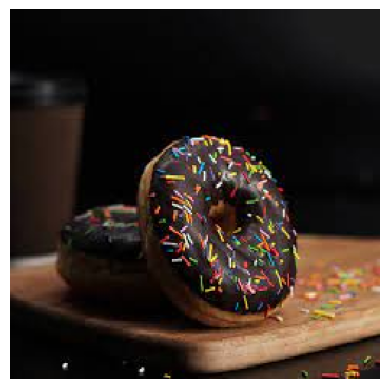

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='food.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess a random image
image_path = random.choice(test['image_path'].tolist())
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], img_array)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)

# Print and display results
print("Predicted class:", Classes[predicted_class])
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="food.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)


[[2.0470975e-03 1.0483332e-03 9.9200320e-01 3.0603381e-03 5.2806520e-04
  9.5969008e-04 3.5337801e-04]]


In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="food.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random images.
test_image_paths = testdf.map(lambda image, label: image)
for test_image_path in test_image_paths.take(5):
  test_image = tf.io.read_file(image_path)
  test_image = decode_img(test_image)
  test_image = tf.expand_dims(test_image, axis=0)

  interpreter.set_tensor(input_details[0]['index'], test_image)
  interpreter.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])
  predicted_label = np.argmax(output_data)
  print("Predicted label:", predicted_label)

Predicted label: 6
Predicted label: 6
Predicted label: 6
Predicted label: 6
Predicted label: 6


# Requirements

In [ ]:
!pip freeze > requirements.txt